<a href="https://colab.research.google.com/github/pulseq/MR-Physics-with-Pulseq/blob/main/tutorials/02_rf_pulses/notebooks/sinc-excitation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Frequency response (slice profile) of the sinc-function
 - approximate solution with STA
 - exact solution computed with scipy.odeint and spinor calculus $^{(1)}$
 - sinc function with or without apodization

(1) Pauly et al. 1991. IEEE TMI 10 (1): 53–65. https://doi.org/10.1109/42.75611 

**Task:** change pulse parameters (e.g. FA, T, TBP, apod) and study the results

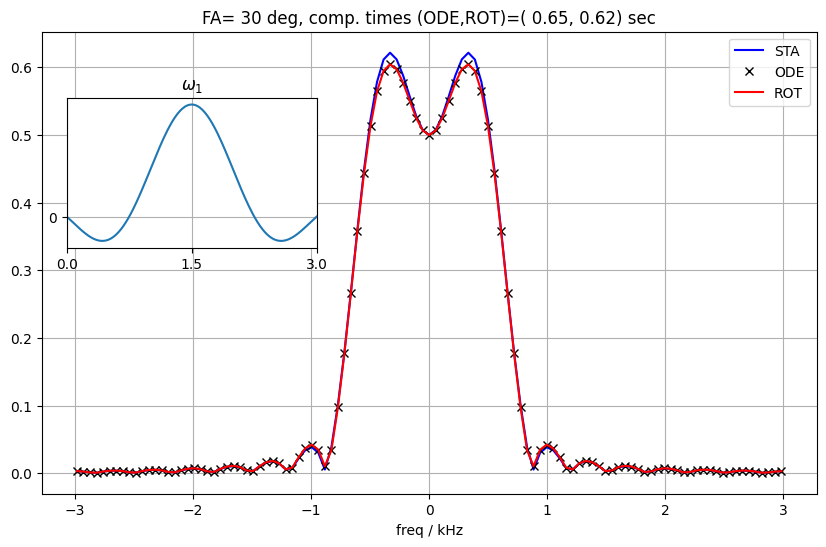

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint  #integrate ODEs 
from scipy.special import sici      # sine/cosine integrals  
import time

FA     = 30               # flip-angle (in degrees)
N      = 200              # number of samples of RF pulse
T      = 3                # duration of RF pulse (in ms)
TBP    = 4                # time-bandwidht product of the RF pulse 
osf    = 6                # oversampling factor to increase resolution of the slice profile
fmax   = 3                # max frequency for plotting (in kHz)
apod   = False            # apodization of sinc-function

t      = np.linspace(0,T,N)     # time axis (in ms)
dt     = t[1]-t[0]              # time spacing
alpha  = FA*np.pi/180           # tip-angle [rad] 

#sinc pulse (in units rad/ms) with or without cosine (Hann) apdodization 
if apod:  
    def omega1(t): return 0.5*(1-np.cos(2*np.pi*t/T))*alpha*np.sinc(TBP*(t-T/2)/T)/(T*sici(TBP*np.pi/2)[0]/(TBP*np.pi/2))
else:
    def omega1(t): return alpha*np.sinc(TBP*(t-T/2)/T)/(T*sici(TBP*np.pi/2)[0]/(TBP*np.pi/2))


#a) small tip angle approximation
FT    = dt*(np.sin(alpha)/alpha)*np.abs(np.fft.fftshift(np.fft.fft(omega1(t),N*osf)))     # STA of pulse 
F     = np.fft.fftshift(np.fft.fftfreq(N*osf,dt))                                         # frequency axis (in kHz)
M_STA = FT[np.abs(F)<fmax]                                                                # solution at ...
F     = F[np.abs(F)<fmax]                                                                 # ... requested frequency range

# measure computation time
CT = time.time()         

# b) ODE solution
M_ODE = np.zeros(len(F))                                                    # result vector  
def bloch(M,t,w): return [ w*M[1], -w*M[0]+omega1(t)*M[2], -omega1(t)*M[1]] # right-hand side of BE
for i in range(len(F)):
    w = 2*np.pi*F[i]                                                 # angular frequency (in rad/ms)
    M        = odeint(bloch, [0.,0.,1.], t,(w,))                     # integrate ODE
    M_ODE[i] = np.sqrt(M[-1,0]**2+M[-1,1]**2)                        # transv. magn. 
CT1 = time.time() - CT

# c) Spinor solution
M_ROT = np.zeros(len(F))                                                    # result vector  
for i in range(len(F)):
    Q  = np.eye(2,dtype=complex)                                     # init Cayley-Klein matrix
    w = 2*np.pi*F[i]                                                 # angular frequency (in rad/ms)
    for j in range(N):
        s = omega1(t[j])                                             # RF pulse signal (in rad/s)
        W = -dt*np.sqrt(np.abs(s)**2+w**2)+np.finfo(float).eps       # effective field rotation angle 
        n = (dt/np.abs(W)) * np.array([s, 0, w])                     # effective field rotation axis
        a = np.cos(W/2)-1j*n[2]*np.sin(W/2)                          # Cayley-Klein parameter alpha             
        b = (-1j*n[0]+n[1])*np.sin(W/2)                              # Cayley-Klein parameter beta 
        Q = np.dot(np.array([[a, -np.conj(b)],[b, np.conj(a)]]),Q )  # chained rotation 
    M_ROT[i] = np.abs(2*np.conj(Q[0,0])*Q[1,0])                      # transverse magnetization 
CT2 = time.time() - CT1 - CT

# plot results
plt.figure(figsize=(10, 6))
plt.plot(F , M_STA , "b" ,    label="STA")
plt.plot(F , M_ODE , "kx",    label="ODE")
plt.plot(F , M_ROT , "r" ,  label="ROT")
plt.xlabel("freq / kHz")
plt.title("FA= %d deg, comp. times (ODE,ROT)=(%5.2f,%5.2f) sec" % (FA,CT1,CT2) )
plt.legend(loc='upper right')
plt.grid(True)
#plot RF pulse in current axis 
plt.axes([0.15, 0.52, .25, .25])
plt.plot(t,omega1(t))
plt.title('$\omega_1$')
plt.xlim(0,T)
plt.xticks([0,T/2,T])
plt.yticks([0])
plt.grid()
plt.show()
